In [2]:
# Import al necessary libraries and packages needed for the project
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image
import pytesseract
from pytesseract import Output
from prettytable import PrettyTable

In [3]:
# PreProcess the image

# Resize Image
def resizeImage(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

# Display grayscale image
def displayGrayImage(image):
    plt.figure(figsize=(16, 10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Approximate contour with primitive polygon shape
def approxContour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

# Find 4 corners in the image
def getContour(contours):
    # Loop through all contours
    for c in contours:
        approx = approxContour(c)
        # If the contour has 4 corners, it can be concluded that it is the desired contour (receipt contour)
        if len(approx) == 4:
            return approx

# Convert 4 corners into connected lines forming a rectangle
def contourToRect(contour):
    points = contour.reshape(4, 2)
    rectangle = np.zeros((4, 2), dtype = np.float32)
    s = points.sum(axis = 1)
    rectangle[0] = points[np.argmin(s)]
    rectangle[2] = points[np.argmax(s)]
    # Calculate the difference between corner points
    # The top-right corner has a smaller difference
    # The bottom-left corner has a larger difference
    difference = np.diff(points, axis = 1)
    rectangle[1] = points[np.argmin(difference)]
    rectangle[3] = points[np.argmax(difference)]
    return rectangle / resizeRatio

# WarpPerspective
def warpPerspective(image, rectangle):
    # Get the corner points
    (tl, tr, br, bl) = rectangle
    # Calculate the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # Calculate the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # Get the maximum values of width and height
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # Define the corner points of the new image
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = np.float32)
    # Calculate the transformation matrix
    matrix = cv2.getPerspectiveTransform(rectangle, dst)
    # WarpPerspective
    return cv2.warpPerspective(image, matrix, (maxWidth, maxHeight))

# Threshold Image
def blackAndWhite(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Display grayscale image
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

# Display grayscale image
def plotGray(image):
    plt.figure(figsize=(16, 10))
    return plt.imshow(image, cmap = "Greys_r")

# Plot RGB image
def plotRGB(image):
    plt.figure(figsize=(16, 10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Find amounts
def findAmounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

In [4]:
filePath = "New Data/train/image/receipt_00016.png"

img = Image.open(filePath)
img.thumbnail((800, 800), Image.ANTIALIAS)
img.show()

C:\Users\hughi\AppData\Local\Temp\ipykernel_17080\3792183612.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img.thumbnail((800, 800), Image.ANTIALIAS)


Recipt Contour Detection

In [5]:
image = cv2.imread(filePath)
resizeRatio = 500 / image.shape[0]
originalimage = image.copy()
image = resizeImage(image, resizeRatio)

Convert to Gray Scale

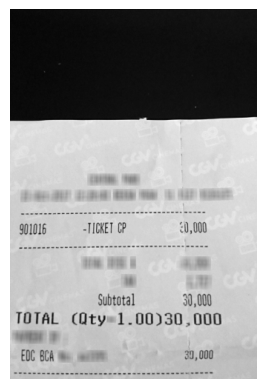

In [9]:
# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Plot the grayscale image
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

Noise Removal

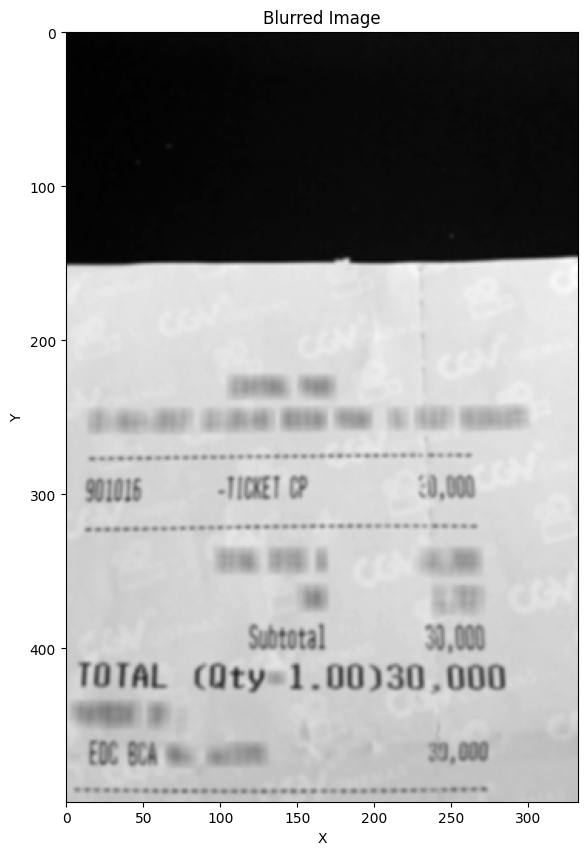

In [11]:
# Apply Gaussian blur to the grayscale image
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Plot the blurred image
plt.figure(figsize=(10, 10))
plt.imshow(blur, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Blurred Image')
plt.show()


Apply dilation for region detection

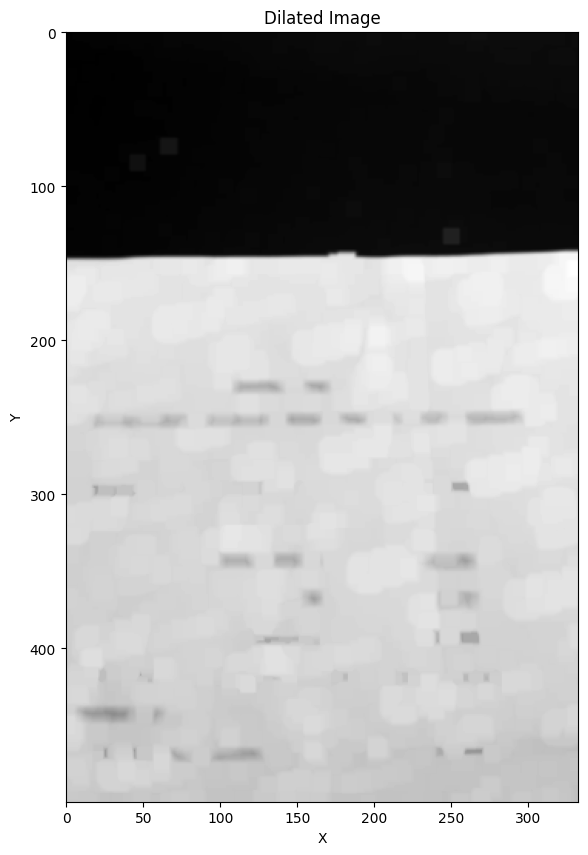

In [14]:
# Define the kernel for dilation
rectangleKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))

# Apply dilation to the blurred image
dilated = cv2.dilate(blur, rectangleKernel)

# Plot the dilated image
plt.figure(figsize=(10, 10))
plt.imshow(dilated, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dilated Image')
plt.show()

Apply Canny Edge Detection

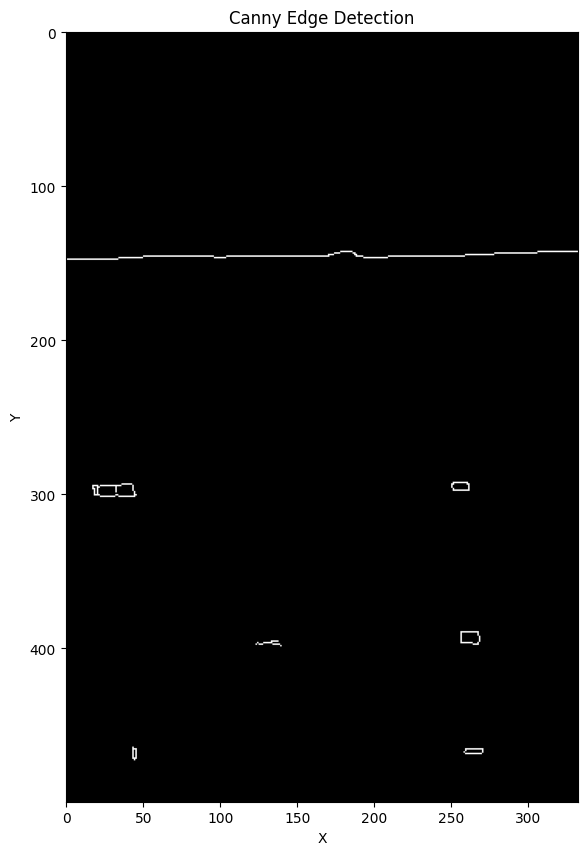

In [15]:
# Apply Canny edge detection
edge = cv2.Canny(dilated, 30, 125, apertureSize=3)

# Display the edge detection result
plt.figure(figsize=(10, 10))
plt.imshow(edge, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Canny Edge Detection')
plt.show()

Detect all contours in a canny-edged image

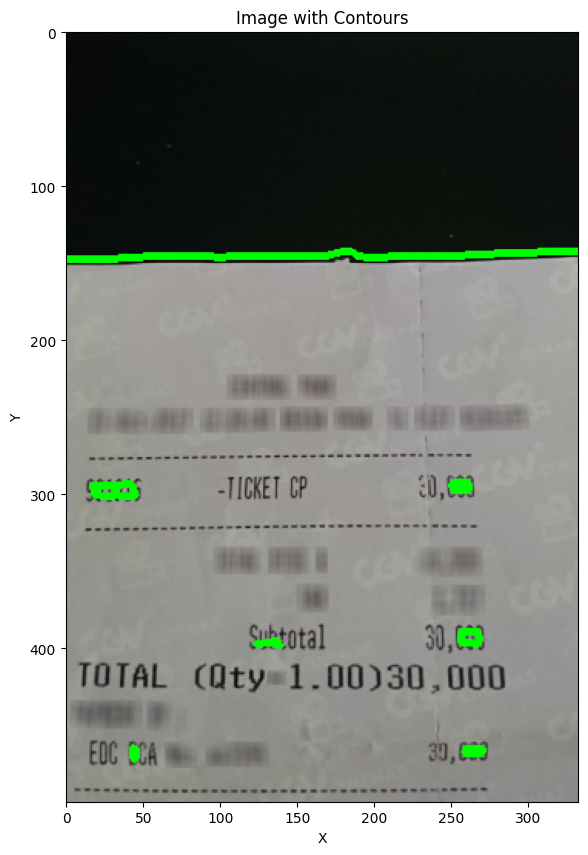

In [16]:
# Find contours in the edge image
contours, hierarchy = cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
imageWithContour = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 3)

# Display the image with contours
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imageWithContour, cv2.COLOR_BGR2RGB))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Image with Contours')
plt.show()

Get the contour with the largest area

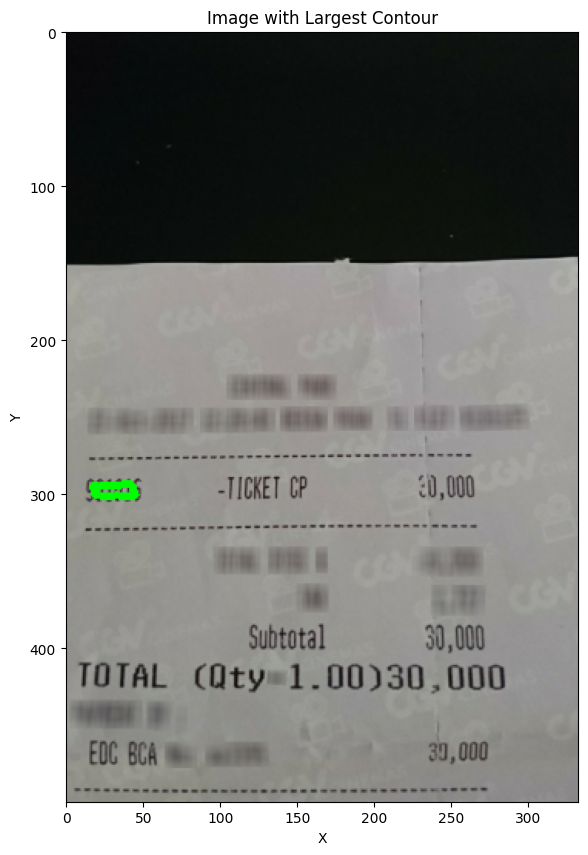

In [17]:
# Find the largest contour
largestContour = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

# Draw the largest contour on the original image
imageWithLargestContour = cv2.drawContours(image.copy(), largestContour, -1, (0, 255, 0), 3)

# Display the image with the largest contour
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imageWithLargestContour, cv2.COLOR_BGR2RGB))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Image with Largest Contour')
plt.show()

In [18]:
getContour(largestContour)

In [19]:
receiptContour = getContour(largestContour)

In [ ]:
# Draw contour of the receipt on the image
imageWithReceiptContour = cv2.drawContours(image.copy(), [receiptContour], -1, (0, 255, 0), 2)

# Display the image with the receipt contour
plotRGB(imageWithReceiptContour)

Show results of contour detection (Crop image)

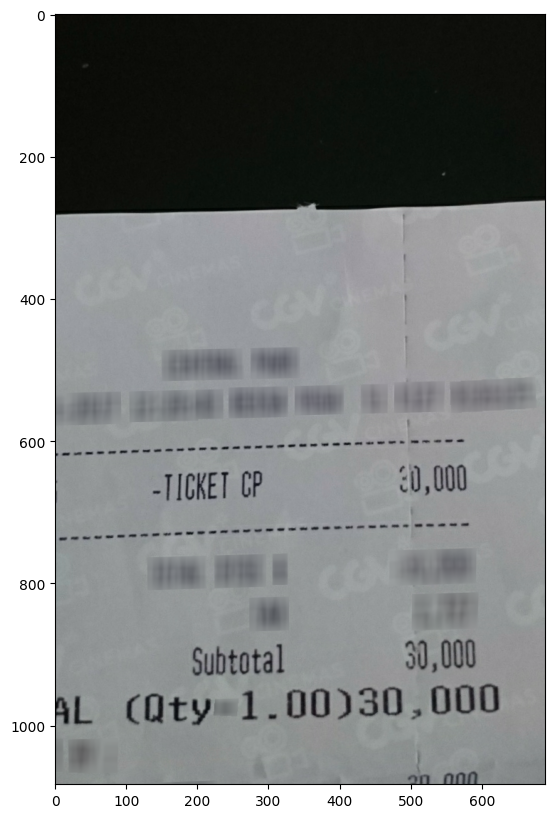

In [222]:
# Warp the perspective of the image based on the receipt contour
scannedContour = warpPerspective(originalimage.copy(), contourToRect(receiptContour))

# Display the scanned contour image
plt.figure(figsize=(16, 10))
plt.imshow(scannedContour)

Thresholding

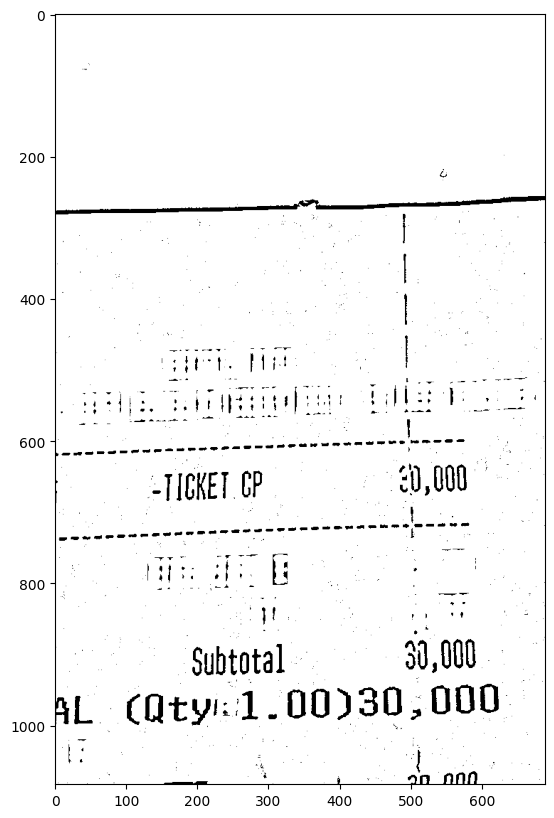

In [223]:
# Convert the scanned contour image to black and white
resultImage = blackAndWhite(scannedContour)

# Display the result image in grayscale
plotGray(resultImage)

In [224]:
# Convert the result image to PIL Image
output = Image.fromarray(resultImage)

# Save the processed image
output.save("Processed/hasil.jpeg")

OCR MODEL

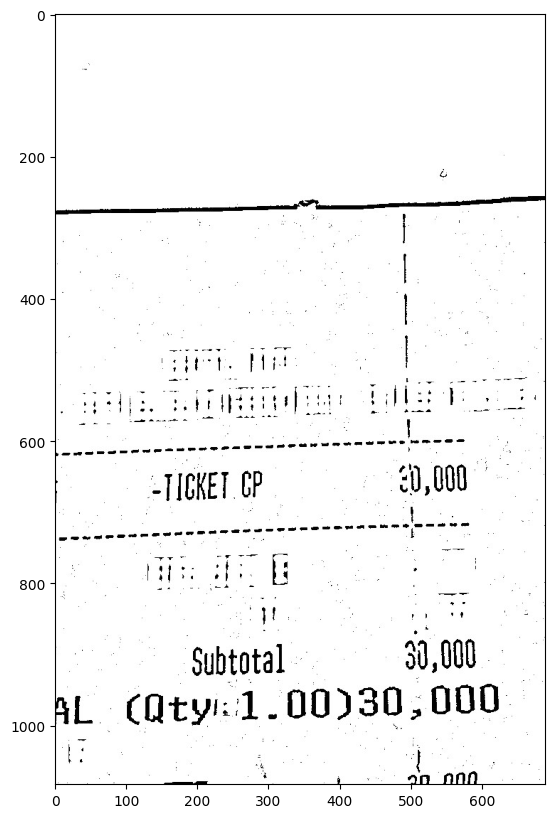

In [225]:
# Specify the file path of the processed image
fileName = "Processed/hasil.jpeg"

# Read the image in grayscale
image = cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)

# Display the grayscale image
plotGray(image)

Text Detection

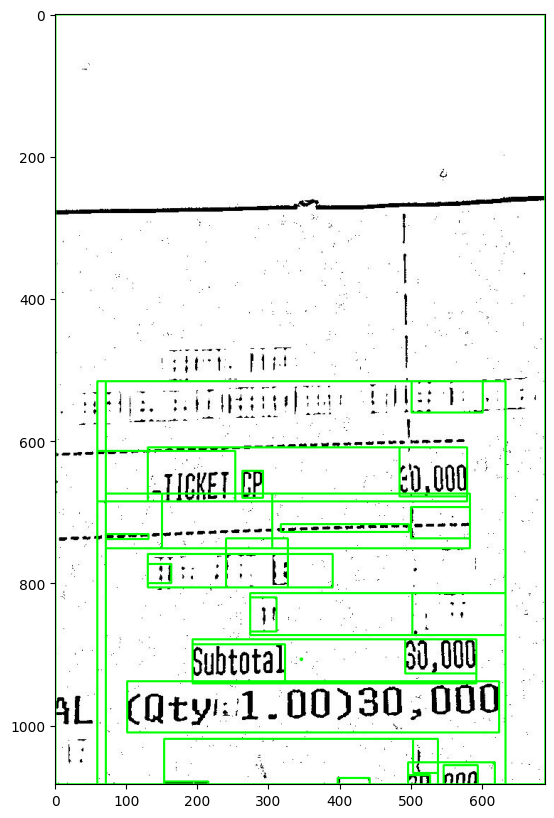

In [226]:
# Perform OCR and get bounding box information
part = pytesseract.image_to_data(image, output_type=Output.DICT)

# Get the number of detected boxes
nBoxes = len(part['level'])

# Create an RGB copy of the image for visualization
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

# Iterate over each detected box and draw a rectangle around it
for i in range(nBoxes):
    # Get the coordinates and dimensions of the box
    (x, y, w, h) = (part['left'][i], part['top'][i], part['width'][i], part['height'][i])
    
    # Draw a rectangle around the box
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the image with bounding boxes
plotRGB(boxes)

Text Recognition

In [227]:
# Set custom configuration for Tesseract OCR
customConfig = r'--oem 3 --psm 6'

# Perform OCR on the image using the custom configuration
text = pytesseract.image_to_string(image, config=customConfig)

# Print the extracted text
print(text)

i
TT
. |
. . oe
cam
OH Rinna) OME
| TICKET CP 2,000
oS HG Boas 2
aT rye ee
Subtotal » 30,000.
AL CQty:1.00)30,000
5 7 "he
a ga 4 aoe a ann”



Apply Regexp

In [256]:
# List of exceptions - words to be excluded from the extracted text
exceptList = ["Subtotal", "Subtotal", "Total", "Tax", "Total Due", "Total Amount", "Amount Due", "Amount", "Due", "Change", "change", "Kembali", "kembali", "Tunai", "Qty"]

# List of words to be removed from the extracted text
removedList = ['vit', 'etc']

In [257]:
#Extract letters and numbers regex
regex_line = []
for line in text.splitlines():
    if re.search(r"[0-9]*\.[0-9]|[0-9]*\,[0-9]", line):
        regex_line.append(line)
print(regex_line)

['| TICKET CP 2,000', 'Subtotal » 30,000.', 'AL CQty:1.00)30,000']


In [258]:
#Apply exclusion list
item = []
for eachLine in regex_line:
    found = False
    for exclude in exceptList:
        if exclude in eachLine.lower():
            found = True
        
    if found == False:
        item.append(eachLine)
print(item)

['| TICKET CP 2,000', 'Subtotal » 30,000.', 'AL CQty:1.00)30,000']


In [259]:
#Word ommit
newItemList = []
for i in item:
    for subToRemove in removedList:
        i = i.replace(subToRemove, "")
        i = i.replace(subToRemove.upper(), "")
    newItemList.append(i)
print(newItemList)

['| TICKET CP 2,000', 'Subtotal » 30,000.', 'AL CQty:1.00)30,000']


Item Cost Regex

In [260]:
#Food item cost regex
item_cost = []
for line in newItemList:
    line = line.replace(",", ".")
    cost = re.findall('\d*\.?\d+|\d*\,?\d+|',line)
    
    for possibleCost in cost:
        if "." in possibleCost:
            item_cost.append(possibleCost)
print(newItemList)

['| TICKET CP 2,000', 'Subtotal » 30,000.', 'AL CQty:1.00)30,000']


Pisahkan Item dan Cost

In [261]:
# Counter for the number of items
count = 0

# List to store only the items without cost
onlyItems = []

# Iterate over each item in the 'newItemList'
for item in newItemList:
    # Variable to store only alphabets and spaces
    only_alpha = ""
    
    # Iterate over each character in the item
    for char in item:
        # Check if the character is alphabetic or a space
        if char.isalpha() or char.isspace():
            only_alpha += char
    
    # Remove single-letter words using regular expression substitution
    only_alpha = re.sub(r'(?:^| )\w(?:$| )', ' ', only_alpha).strip()
    
    # Append the modified item to the 'onlyItems' list
    onlyItems.append(only_alpha)

# Print the list of items without cost
print(onlyItems)

['TICKET CP', 'Subtotal', 'AL CQty']


In [262]:
# List to store the modified items
thing = []

# Iterate over each item in 'onlyItems'
for item in onlyItems:
    # Split the item into individual words
    temp = item.split()

    # Omit words with length 2
    res = [ele for ele in temp if len(ele) != 2]

    # Join the remaining words back into a string
    res = ' '.join(res)
    
    # Append the modified item to the 'thing' list
    thing.append(res)

# Print the modified items
print(thing)

['TICKET', 'Subtotal', 'CQty']


Output

In [263]:
# Create a new table with columns 'Item' and 'Cost'
t = PrettyTable(['Item', 'Cost'])

# Iterate over the range of indices of word list
for counter in range(0, len(thing)):
    # Add a new row to the table with the item and corresponding cost
    t.add_row([thing[counter], item_cost[counter]])

# Print the table
print(t)

+----------+--------+
|   Item   |  Cost  |
+----------+--------+
|  TICKET  | 2.000  |
| Subtotal | 30.000 |
|   CQty   |  1.00  |
+----------+--------+
